In [29]:
from music21 import *
import glob
import sys

----

## Harmonies as Modes - Data extraction

Authors: Sebastian Klaßmann, Christoph Finkensiep
July 21$^{st}$, 2020  

---

**Wishlist for data abstraction:**

- [X] parse harmonies of a given piece given by annotation and identify which notes belong to a given chord based on onset.
- [ ] chord vocabulary - start from basic tetrads, aka. chord types
- [X] list of tuples of (pitch classes, note types)
- [ ] pitch encoding based on line of fifths
- [ ] consider neighboring notes for classification as embellishments
- [X] helper function that corrects chord offsets
- [ ] syncopated notes are still treated in a strange fashion. i.e.: the code so far does not consider a syncopated note that is a clear anticipation of a chord on the next beat as belonging to that chord.

**Summary so far:**
* current pitch class rep uses 12 pc, need conversion to TPC (line of fifth)
    * this closely ties in with the representation of chord symbol root notes
* still need a way to convert chord symbols to chord types via dict
* currently, NPC are stored for encountered melody notes
* currently, function only differentiates between ct and unknown $\rightarrow$ discuss

In [3]:
pc = converter.parse('de_dont_mean.mxl') # can be used for demonstration.

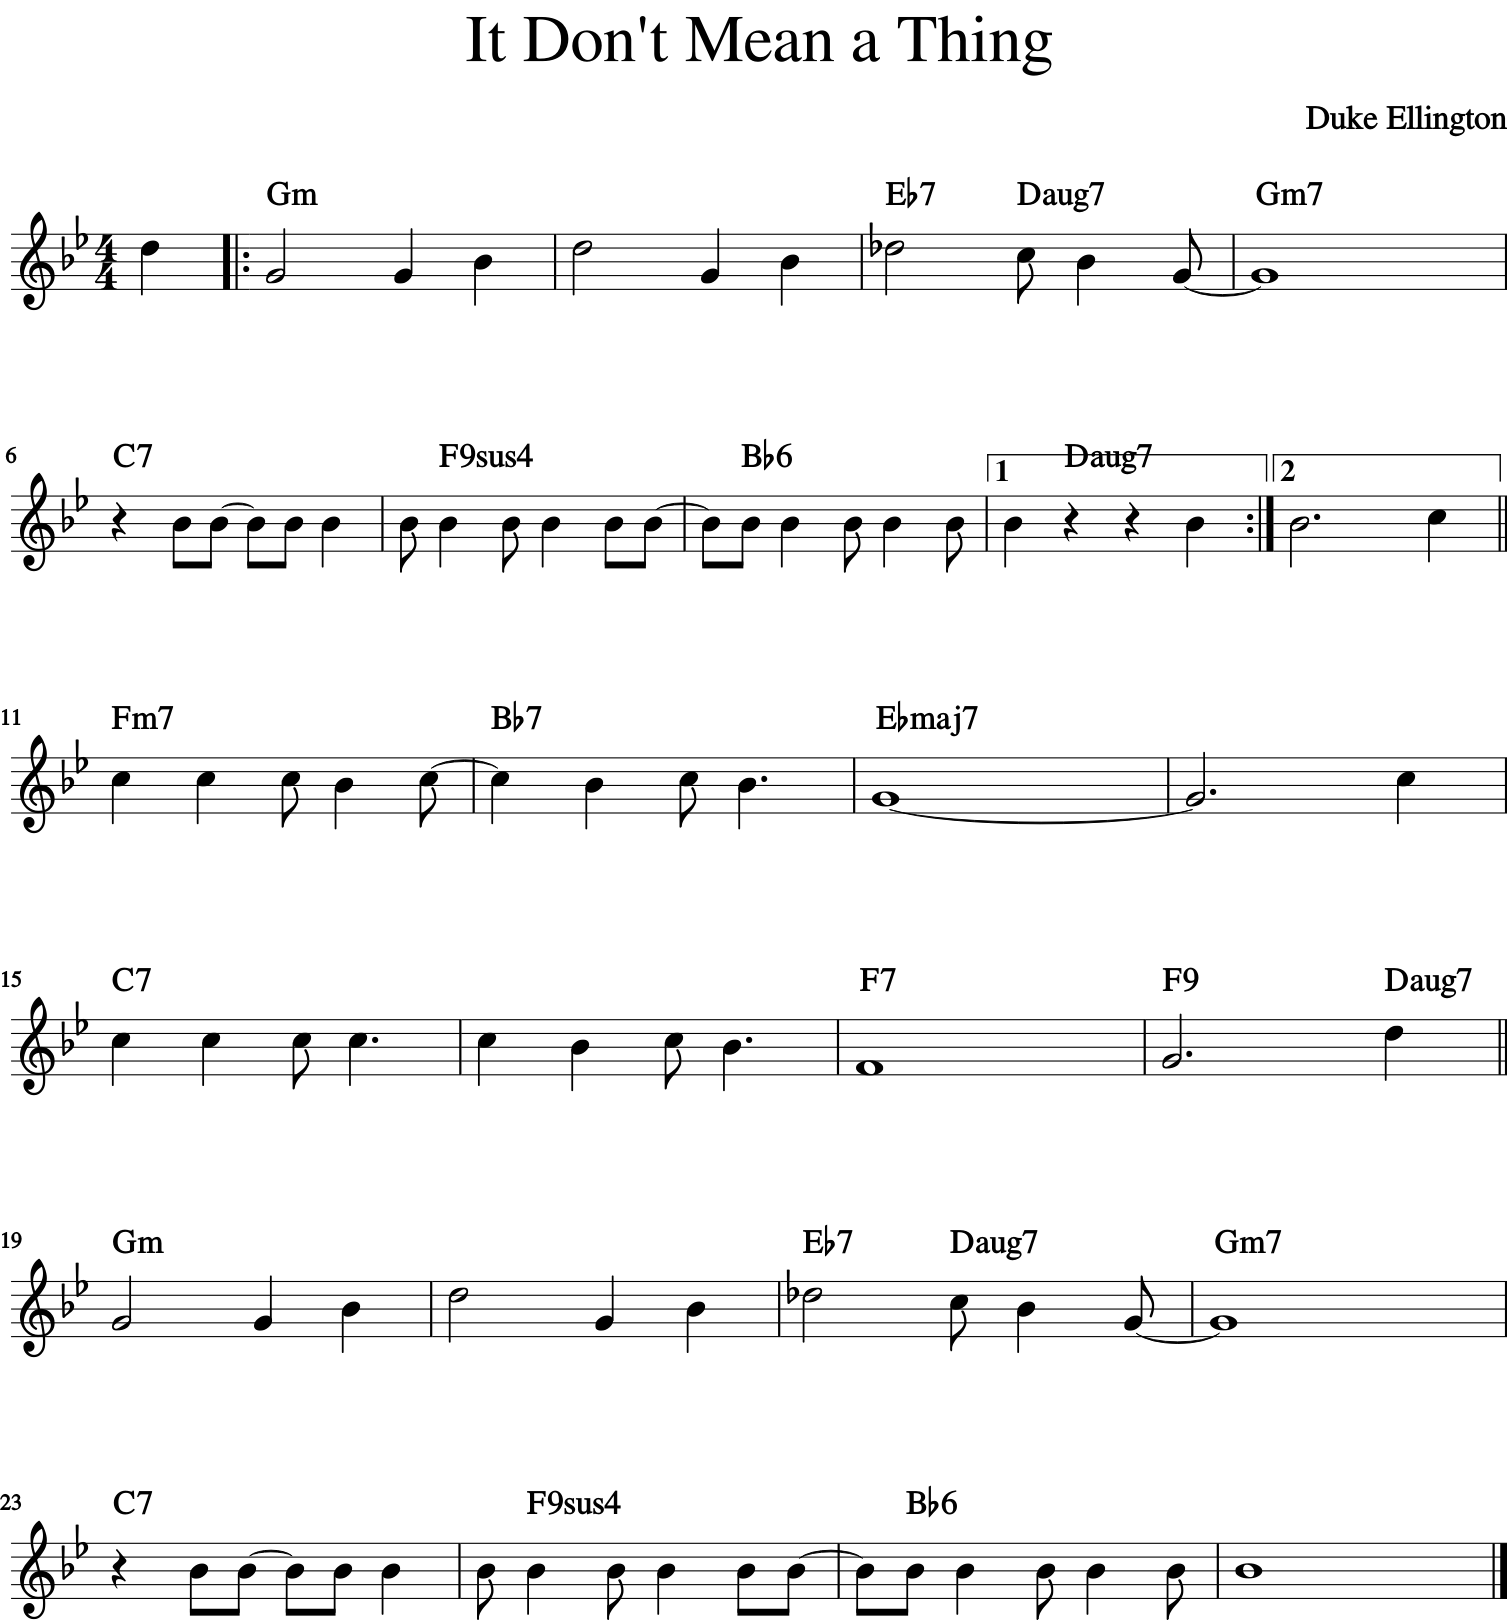

In [4]:
pc.show()

In [30]:
## helper functions:
def getabsoffset(musob):
    """
    assumes the passed object "musob" to be a music21 object that has a music21.offset property.
    will return the absolute offset of musob in relation to the stream it is contained in by calculating
    the sum of it's own offset in relation to it's active site and the offset of the activeSite (i.e., of the measure
    it is contained in)
    """
    return musob.activeSite.offset + musob.offset

def fixhos(offset):
    """
    Assumes chordlist to be a list of lists of harmonies and their absolute offsets filtered from a music21 stream.
    returns a list of rhythmically connected offsets that place chords on the beat to avoid labelling errors.
    
    Still preliminary, as it changes the chord symbol's offset by substracting 0.5 from it.
    """
    return round(offset-sys.float_info.epsilon,0)

def chtypecon(harmlist, typedict={}):
    """
    Assumes harmlist to be a list of harmonies yielded by getnotes().
    Queries the kind of chord symbol (i.e., chord type) of all chord symbols in harmlist, builds a chord type dictionary for the stream at hand.    
    """
    for harm in harmlist:
        typedict = {k:v for (k,v) in zip(chordtypes, range(numchordtypes))}

In [31]:
chordex = [] # start from empty list of chords

def getharmonies(pc):

    """
    assumes a preprocessed MusicXML or MIDI file to have been passed to music21's converter.parse()
    This function will recursively filter the resulting music21.stream.Stream object for notes and chord symbols.
    If a chord symbol is found, this function will consider all notes found inside the stream between this and the next
    chord symbol to be in relation to the found chord symbol and return a list of harmonies.
    One harmony will be encoded as a list containing the harmonic type of the found harmony, as well as tuples containing
    the pitch classes of melody notes related to that harmony and their observed note type (chord tone, embellishment, unknown)
    """  

    harmonies = []
    # tempch = ['unknown'] # if a note is present before a first chord annotation appears in the score.
    for const in pc: # topmost level of nesting, assumes tht at the second level, we are already looking at streams.
        if isinstance(const, stream.Stream): # only look at streams inside stream, including parts and measures
            for measure in const: # next level of nesting: filter out measure, ignore metadata
                if isinstance(measure, stream.Measure): # ignore metadata and instruments:
                    for element in measure: # look at elemnts in measures
                        if isinstance(element, harmony.ChordSymbol): # check if current element is chord symbol
                            harmonies.append((element, fixhos(getabsoffset(element))))
    
    endofpiece = pc.flat.highestOffset + 1.0
    offsets = [onset for (_,onset) in harmonies][1:]# destructuring
    offsets.append(endofpiece)
    harmonies = [(harmony, onset, offset) for ((harmony, onset),offset) in zip(harmonies, offsets)]
    return harmonies

In [15]:
pc.flat.highestOffset + 1.0

102.0

In [17]:
harm = getharmonies(pc)
print(harm)

[(<music21.harmony.ChordSymbol Gm>, 1.0, 9.0), (<music21.harmony.ChordSymbol E-7>, 9.0, 11.0), (<music21.harmony.ChordSymbol D7+>, 11.0, 13.0), (<music21.harmony.ChordSymbol Gm7>, 13.0, 17.0), (<music21.harmony.ChordSymbol C7>, 17.0, 21.5), (<music21.harmony.ChordSymbol Fsus add 7 add 9>, 21.5, 25.5), (<music21.harmony.ChordSymbol B-6>, 25.5, 30.0), (<music21.harmony.ChordSymbol D7+>, 30.0, 37.0), (<music21.harmony.ChordSymbol Fm7>, 37.0, 41.0), (<music21.harmony.ChordSymbol B-7>, 41.0, 45.0), (<music21.harmony.ChordSymbol E-maj7>, 45.0, 53.0), (<music21.harmony.ChordSymbol C7>, 53.0, 61.0), (<music21.harmony.ChordSymbol F7>, 61.0, 65.0), (<music21.harmony.ChordSymbol F9>, 65.0, 68.0), (<music21.harmony.ChordSymbol D7+>, 68.0, 69.0), (<music21.harmony.ChordSymbol Gm>, 69.0, 77.0), (<music21.harmony.ChordSymbol E-7>, 77.0, 79.0), (<music21.harmony.ChordSymbol D7+>, 79.0, 81.0), (<music21.harmony.ChordSymbol Gm7>, 81.0, 85.0), (<music21.harmony.ChordSymbol C7>, 85.0, 89.5), (<music21.har

In [14]:
# check for root octave encoding:  
harm[0][0].duration

<music21.duration.Duration 0.0>

In [66]:
spellpc(c.pitch)

-21

In [18]:
def getchordtones(harmony):
    """
    assumes harmony to be harmony.ChordSymbol
    returns chord tones from harmony
    """
    return [element.pitch.pitchClass for element in harmony]

In [70]:
def isneighbour(p1,p2):
    return abs(p1-p2)%7 == 2

In [71]:
def notetype(pitch, pitches, chordtones):
    hasneighbour = any(isneighbour(p, pitch) for p in pitches) # any uses iterator here
    
    if not hasneighbour: # if there is no identifiable neighbour, tone has to be chord tone
        return 'chordtone'
    elif not pitch in chordtones and hasneighbour:
        return 'ornament'
    else:
        return 'unknown'

In [26]:
def getlabel(harmony):
    return harmony.chordKind

In [69]:
def spellpc(pitch):
    diastemtone = (pitch.diatonicNoteNum - 1 ) % 7
    diafifths = (diastemtone * 2 + 1) % 7 - 1
    fifths = diafifths + int(pitch.alter) * 7
    return fifths

In [24]:
notetype(5, [1,5,7], None)

True

In [79]:
def getnotes(pc):
    
    """
    assumes a preprocessed MusicXML or MIDI file to have been passed to music21's converter.parse()
    This function will first call "getharmonies" on the given stream to work from a list of Chord Symbol Objects
    and their absolute offsets. It then iterates over all harmonies and filters the stream for notes at offsets in 
    relation to these harmonies.
    As it does so by iterating over a flattened instance of the given stream, it should also work for polyphonic streams,
    given that they contain chord labelling as Chord Symbols.

    For now, the last harmony is not processed correctly.
    """ 
    
    harm = getharmonies(pc) # parse chord symbols, calls function getharmonies
    harmonies = [] # start from empty list
    for currharm, curros, nextos in harm: # iterate over all elements of harm 
        
        if currharm.root() == None:
            continue
        else:
            root = spellpc(currharm.root())
        
        chordtones = getchordtones(currharm)    
        
        sIter = pc.flat.getElementsByClass(note.Note).iter # create iterator over stream
        offFilter = stream.filters.OffsetFilter(curros, nextos) # filter stream by offset specified by currharm
        offIter = sIter.addFilter(offFilter) # add filter to iterator
        pitches = [spellpc(el.pitch) for el in offIter if getabsoffset(el) < nextos] 
        
            
        notes = [(pitch-root, notetype(pitch, pitches, chordtones)) for pitch in pitches]
             
        harmonies.append((getlabel(currharm),notes))
        
    return(harmonies)      

In [80]:
print(getnotes(pc))

[('minor', [(0, 'chordtone'), (0, 'chordtone'), (-3, 'chordtone'), (1, 'chordtone'), (0, 'chordtone'), (-3, 'chordtone')]), ('dominant', [(-2, 'chordtone')]), ('augmented-seventh', [(-2, 'unknown'), (-4, 'ornament'), (-1, 'chordtone')]), ('minor-seventh', [(0, 'chordtone')]), ('dominant', [(-2, 'chordtone'), (-2, 'chordtone'), (-2, 'chordtone'), (-2, 'chordtone'), (-2, 'chordtone'), (-2, 'chordtone'), (-2, 'chordtone')]), ('suspended-fourth', [(-1, 'chordtone'), (-1, 'chordtone'), (-1, 'chordtone'), (-1, 'chordtone'), (-1, 'chordtone'), (-1, 'chordtone')]), ('major-sixth', [(0, 'chordtone'), (0, 'chordtone'), (0, 'chordtone'), (0, 'chordtone'), (0, 'chordtone')]), ('augmented-seventh', [(-4, 'ornament'), (-4, 'ornament'), (-2, 'unknown')]), ('minor-seventh', [(1, 'unknown'), (1, 'unknown'), (1, 'unknown'), (-1, 'ornament'), (1, 'unknown')]), ('dominant', [(2, 'ornament'), (0, 'ornament'), (2, 'ornament'), (0, 'ornament')]), ('major-seventh', [(4, 'chordtone'), (4, 'chordtone'), (3, 'ch

---

## Applying everything to a given corpus

* Please note:
    * For experimentation purposes, Wikifonia was used. As there might be copyright infringement issues, the corpus will not be pushed to GitHub.
    * As of now, the music21 converter (converter.parse()) seems to run into a problem when encountering certain harmony extensions. Therefore, the below cell still terminates at a fixed point and only returns approx. 45000 harmonies.

In [81]:
allharm = []
for file in glob.glob("wikifonia/*.mxl"):
    # look for all files with the .mxl extension in our source folder
        
        pc = converter.parse(file)
        # use music21's converter.parse() to convert them to music21 objects and store them within a stream "midi"
        
        allharm += getnotes(pc)

ChordStepModificationException: Degree not in specified chord: 9

In [82]:
len(allharm)

44321

In [20]:
print(allharm[0])

[<music21.harmony.ChordSymbol C>, (8, 0), (8, 0), (0, 0)]
